In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Experimental_Results/Comparision_with_other_models/SSL_scripts")

In [ ]:
import os
import numpy as np
import cv2
from skimage import io, filters, morphology, measure, segmentation,exposure, data, img_as_float
from scipy.ndimage import binary_fill_holes
import pandas as pd
import matplotlib.pyplot as plt
from utils import (create_folder, ReadDataCube, findMinConnectedRegion, normalize_to_uint8,
                   OF_CellvsBackgroundTraining, OpticalFlowSeg, im2uint8_matlab_style)
from tqdm.notebook import tqdm

from Classifiers import GenFeatureVectorsTrain, GenFeatureVectorsTest, Bayes_S_G_I_trainClassifier

target_h, target_w = 1440, 1920
def ReadDataCube(dir_str):
    target_h, target_w = 1440, 1920  # hardcoded center crop size

    files = [f for f in os.listdir(dir_str) if os.path.isfile(os.path.join(dir_str, f))]
    imgs = []

    for f in files:
        path = os.path.join(dir_str, f)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Skipping unreadable file: {f}")
            continue
        imgs.append(img)

    # Preview first image
    sample_img = imgs[0]
    h, w = sample_img.shape
    start_y = (h - target_h) // 2
    start_x = (w - target_w) // 2
    cropped_sample = sample_img[start_y:start_y+target_h, start_x:start_x+target_w]

    # Show preview
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(sample_img, cmap='gray')
    plt.title(f"Original ({h}x{w})")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cropped_sample, cmap='gray')
    plt.title(f"Cropped ({target_h}x{target_w})")
    plt.axis('off')
    plt.show()

    # Crop all images
    cropped_imgs = []
    for img in imgs:
        h, w = img.shape
        start_y = (h - target_h) // 2
        start_x = (w - target_w) // 2
        cropped = img[start_y:start_y+target_h, start_x:start_x+target_w]
        cropped_imgs.append(cropped)

    out = np.stack(cropped_imgs, axis=-1)
    return out, files

In [ ]:
fail_dir = "/content/segmentation_failures"
os.makedirs(fail_dir, exist_ok=True)

def save_failure_image(message, filename, img_shape):
    h, w = img_shape
    img = np.zeros((h, w, 3), dtype=np.uint8)  # Black background

    # Choose font size based on image size
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = max(min(w, h) / 900, 1)  # scale text for large images
    thickness = max(int(min(w, h) / 300), 2)

    # Get text size for centering
    text_size = cv2.getTextSize(message, font, font_scale, thickness)[0]
    text_x = (w - text_size[0]) // 2
    text_y = (h + text_size[1]) // 2

    # Add text
    cv2.putText(img, message, (text_x, text_y), font, font_scale,
                (255, 255, 255), thickness, cv2.LINE_AA)

    # Save as PNG for visibility
    out_path = os.path.join(fail_dir, os.path.splitext(filename)[0] + ".png")
    cv2.imwrite(out_path, img)
    print(f"⚠️ Saved failure image: {out_path}")

Folder "/content/SSL_mask" already exists.
Folder "/content/SSL_segmentation" already exists.
Folder "/content/SSL_label" already exists.


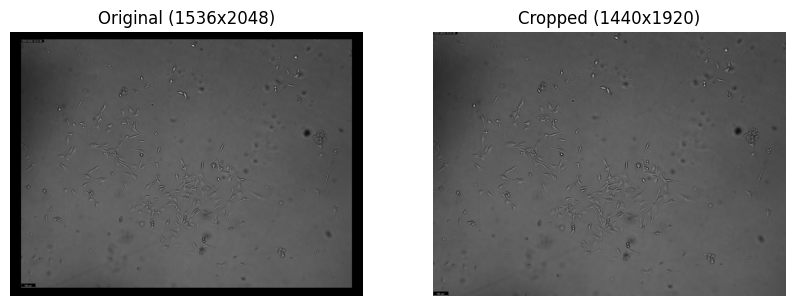

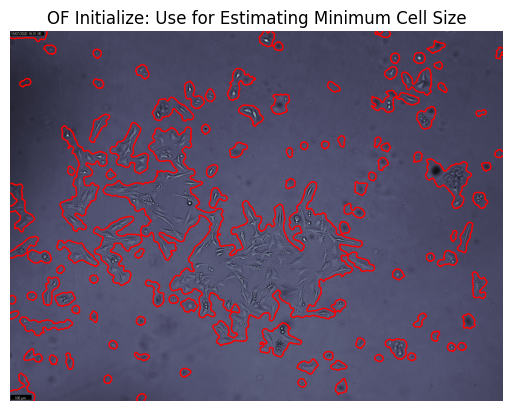

Working Progress: Optical Flow Supervised Using Entropy on image 1 of this dataset
MinArea: 1445
Time taken for 07.jpg: 39.53 seconds


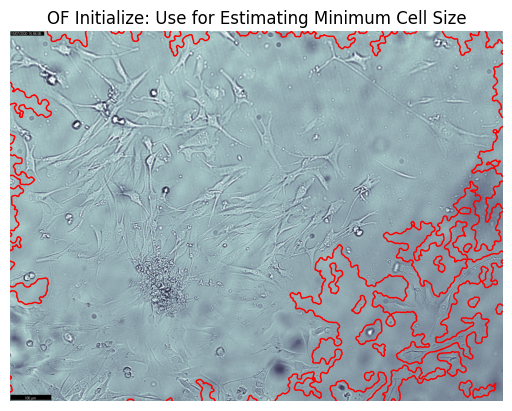

Working Progress: Optical Flow Supervised Using Entropy on image 2 of this dataset
MinArea: 37036
Either no cells found or all cells are touching the border: 06.jpg
⚠️ Saved failure image: /content/segmentation_failures/06.png


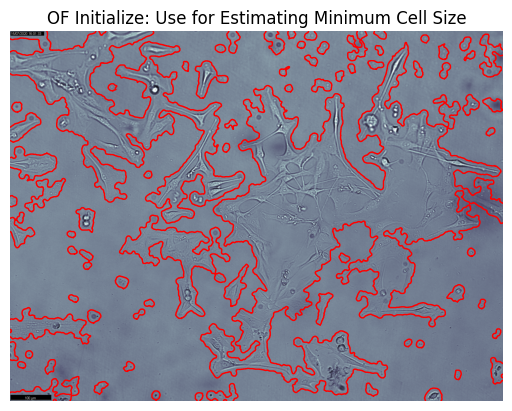

Working Progress: Optical Flow Supervised Using Entropy on image 3 of this dataset
MinArea: 3661
Time taken for 08.jpg: 56.09 seconds


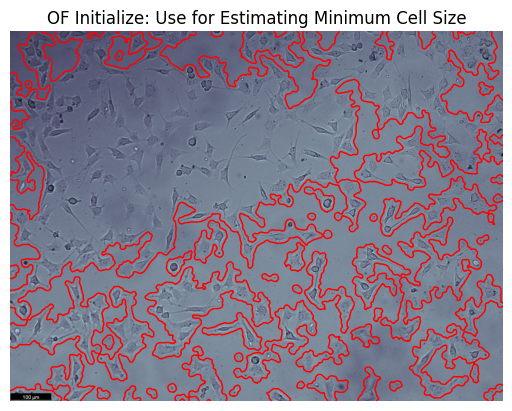

Working Progress: Optical Flow Supervised Using Entropy on image 4 of this dataset
MinArea: 8557
Either no cells found or all cells are touching the border: 03.jpg
⚠️ Saved failure image: /content/segmentation_failures/03.png


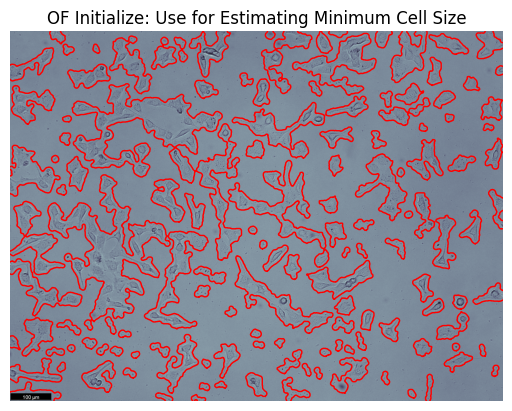

Working Progress: Optical Flow Supervised Using Entropy on image 5 of this dataset
MinArea: 1643
Time taken for 05.jpg: 51.19 seconds


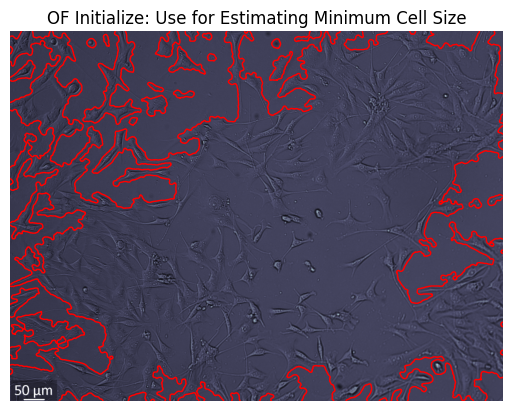

Working Progress: Optical Flow Supervised Using Entropy on image 6 of this dataset
MinArea: 21495
Either no cells found or all cells are touching the border: 10.jpg
⚠️ Saved failure image: /content/segmentation_failures/10.png


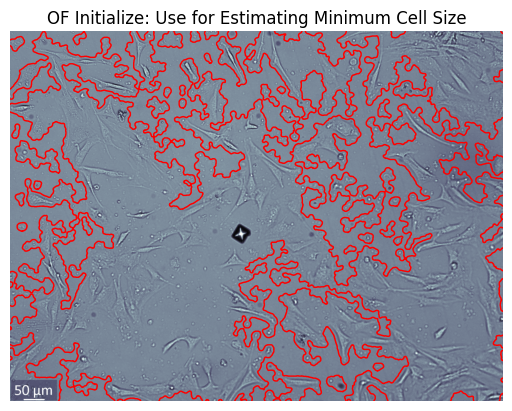

Working Progress: Optical Flow Supervised Using Entropy on image 7 of this dataset
MinArea: 13575
Either no cells found or all cells are touching the border: 04.jpg
⚠️ Saved failure image: /content/segmentation_failures/04.png


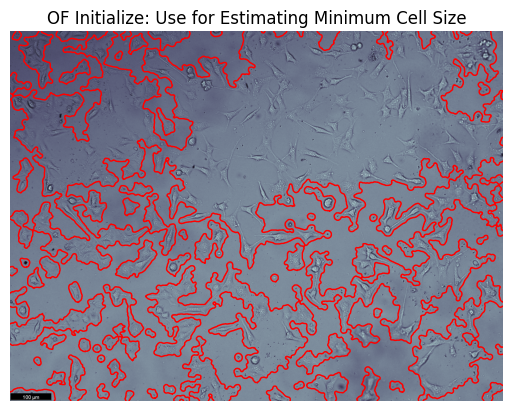

Working Progress: Optical Flow Supervised Using Entropy on image 8 of this dataset
MinArea: 6033
Either no cells found or all cells are touching the border: 02.jpg
⚠️ Saved failure image: /content/segmentation_failures/02.png


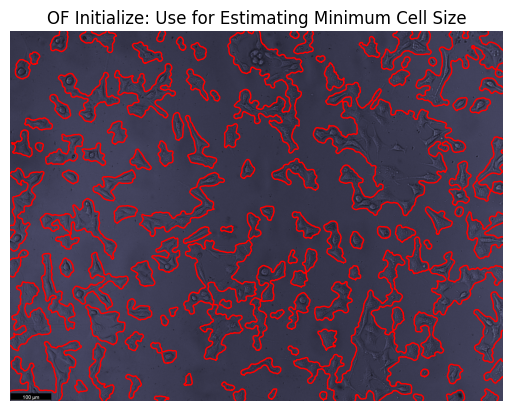

Working Progress: Optical Flow Supervised Using Entropy on image 9 of this dataset
MinArea: 2095
Time taken for 01.jpg: 34.71 seconds


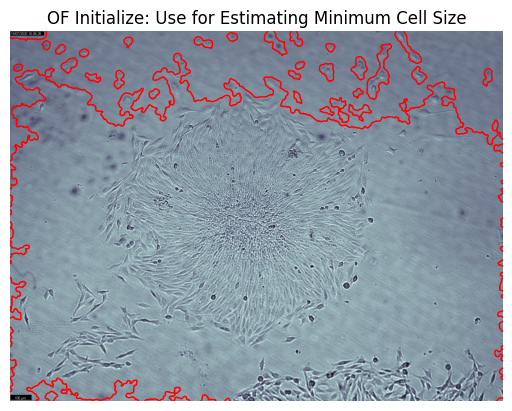

Working Progress: Optical Flow Supervised Using Entropy on image 10 of this dataset
MinArea: 17986
Either no cells found or all cells are touching the border: 09.jpg
⚠️ Saved failure image: /content/segmentation_failures/09.png


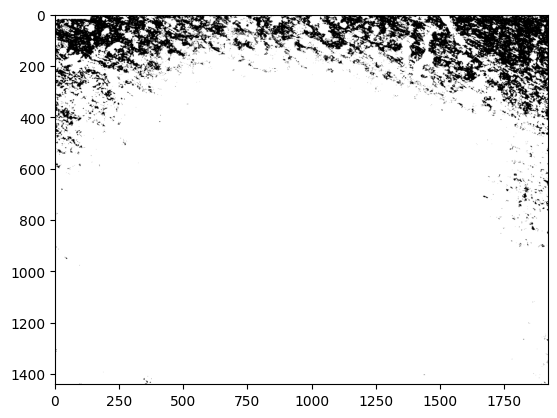

In [ ]:
# --- Directories ---
dir_str = r'/content/drive/MyDrive/Experimental_Results/Comparision_with_other_models/10_Lab_img'
# Backbone directory where all results will be stored
output_root = "/content/"  # change this to your desired root

folder_mask = 'SSL_mask'
folder_result = 'SSL_segmentation'
folder_label = 'SSL_label'

# Create full paths under output_root
folder_mask_path = os.path.join(output_root, folder_mask)
folder_result_path = os.path.join(output_root, folder_result)
folder_label_path = os.path.join(output_root, folder_label)

# Create folders
create_folder(folder_mask_path)
create_folder(folder_result_path)
create_folder(folder_label_path)

S_nhood = np.ones((7, 7), dtype=bool)
size_of_smoothing_disk = 5

# Part 1: Feature vector, boosting techniques, and image annotation

extra_S = 1e4



# Part 2: Read in imagery and microscope metadata
I, ImgInfo = ReadDataCube(dir_str)
rows, cols, num_of_frames = I.shape

sim = np.zeros((rows, cols), dtype=bool)
BW_OF_pair = np.zeros((rows, cols, 2), dtype=bool)
BW = np.zeros((rows, cols, num_of_frames), dtype=bool)
BW_cube_fv = np.zeros((rows, cols, num_of_frames), dtype=bool)
pre_BW_cube = np.zeros((rows, cols, 1), dtype=bool)

label = ['background', 'cell']
brightness_factor = 1

fail_dir = "/content/segmentation_failures"
failure_names = {os.path.splitext(f)[0] for f in os.listdir(fail_dir)}

import time

# Part 3: Determine MinPixelsInConnectedRegion
for k in range(num_of_frames):
    start_time = time.time() # Start timer

    img = I[:, :, k]
    filename = ImgInfo[k]
    #MinArea, B_OF, img_pair, mag = findMinConnectedRegion(img)
    MinArea, B_OF, img_pair, mag = findMinConnectedRegion(img)
    #img_pair = normalize_to_uint8(img_pair)
    # Skip if already failed before
    base_name = os.path.splitext(filename)[0]
    if base_name in failure_names:
        print(f"⚠️ Skipping {filename} (already in failures)")
        continue

    ## Plotting image and segmentation result using only OF
    fig = plt.gcf()  # Get the current figure, if one is already open
    plt.imshow(np.clip(img_as_float(img) * brightness_factor,0,1),cmap ='bone')
    for i in range(len(B_OF)):
        bdd_OF = B_OF[i]
        plt.plot(bdd_OF[:, 1], bdd_OF[:, 0], 'r', linewidth=1)  # Plot on the existing figure

    plt.title('OF Initialize: Use for Estimating Minimum Cell Size')
    plt.axis('off')
    #plt.pause(0.01)
    plt.show()

    print(f"Working Progress: Optical Flow Supervised Using Entropy on image {k+1} of this dataset")
    print(f"MinArea: {MinArea}")
    bg_train, cell_train = OF_CellvsBackgroundTraining(img_pair, MinArea, S_nhood, extra_S)
    BW_bg_train = bg_train.astype(bool)
    BW_cell_train = cell_train.astype(bool)

    img_entropy = filters.rank.entropy(img, S_nhood)
    bin_img_entropy = (img_entropy == 0)
    img_entropy += 0.001 * bin_img_entropy

    FV_table_train = GenFeatureVectorsTrain(img, BW_bg_train, BW_cell_train, S_nhood, label)
    FV_table_test = GenFeatureVectorsTest(img, S_nhood)

    trainedClassifier, validationAccuracy = Bayes_S_G_I_trainClassifier(FV_table_train)
    accuracy = validationAccuracy

    yfit = trainedClassifier['predictFcn'](FV_table_test)

    p = 0
    for i in range(rows):
        for j in range(cols):
            BW[i, j, k] = (yfit[p] == 'cell')
            p += 1

    plt.imshow(BW[:,:,k], cmap='gray')

    BW_2 = morphology.remove_small_objects(BW[:,:,k], MinArea,connectivity = 2)
    se = morphology.disk(size_of_smoothing_disk)
    clzBW = morphology.binary_closing(BW_2, se)
    pre_BW_cube = binary_fill_holes(clzBW.astype(bool))
    pre_BW_cube = segmentation.clear_border(pre_BW_cube)
    pre_L = measure.label(pre_BW_cube,connectivity =2)

    if np.sum(pre_L) == 0:
      msg = f"Either no cells found or all cells are touching the border: {filename}"
      print(msg)
      save_failure_image(msg, filename, img.shape)  # use original img shape
      continue


    BW_cube_fv[:, :, k] = pre_BW_cube

    L, num_cells = measure.label(BW_cube_fv[:, :, k], connectivity =2, return_num=True)
    stats = measure.regionprops_table(L, properties=('label','area', 'perimeter', 'eccentricity',
                                                'axis_major_length', 'axis_minor_length',
                                                'feret_diameter_max', 'centroid','orientation','solidity')
                                      )

    stats_df = pd.DataFrame(stats)
    num_labels = stats_df.shape[0]
    CellInfo = []
    CellLabel = []
    cell_OF = []
    cell_S = []

    for j in range(1, num_labels + 1):
    # Calculate cell properties
        cell_OF.append(np.sum(mag[L == j]))
        cell_S.append(np.sum(img_entropy[L == j]))
        CellInfo.append(os.path.splitext(filename)[0])  # Replace with actual image info
        CellLabel.append(j)

    # Step 4: Convert to DataFrames and combine them
    OF_S_Table = pd.DataFrame({'OF_mag': cell_OF, 'entropy': cell_S})
    Cellinfo_Table = pd.DataFrame({'Image Name': CellInfo})
    CellLabel_Table = pd.DataFrame({'Cell Label': CellLabel})

    # Combine all tables
    params = pd.concat([Cellinfo_Table, CellLabel_Table, stats_df, OF_S_Table], axis=1)
    params_filename = 'Geometric_Data.xlsx'
    params.to_excel(os.path.join(dir_str,params_filename), index=False)

    # Display the final DataFrame


    # Clear variables (optional in Python, but keeping for clarity)
    del cell_OF, cell_S
    plt.close()

    import imageio.v2 as imageio
    boundaries = measure.find_contours(BW_cube_fv[:, :, k], level=0.5)
    # Save boundary overlay (result)
    figurename = os.path.splitext(filename)[0] + '.png'
    overlay_img = np.clip(img_as_float(img) * brightness_factor, 0, 1)
    plt.imshow(overlay_img, cmap='bone')
    for boundary in boundaries:
        plt.plot(boundary[:, 1], boundary[:, 0], 'y', linewidth=0.5)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join(folder_result_path, figurename), dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Save labeled overlay
    figurename2 = os.path.splitext(filename)[0] + '.png'
    plt.imshow(overlay_img, cmap='bone')
    for boundary in boundaries:
        plt.plot(boundary[:, 1], boundary[:, 0], 'y', linewidth=0.5)
    for m, (y, x) in enumerate(zip(stats_df['centroid-0'], stats_df['centroid-1']), start=1):
        plt.text(x, y, str(m), color='red', fontsize=8)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join(folder_label_path, figurename2), dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Save binary mask (exact array size)
    mask_path = os.path.join(folder_mask_path, os.path.splitext(filename)[0] + '.png')
    mask_uint8 = (BW_cube_fv[:,:,k] > 0).astype(np.uint8) * 255
    imageio.imwrite(mask_path, mask_uint8)

    end_time = time.time() # End timer
    print(f"Time taken for {filename}: {end_time - start_time:.2f} seconds") # Print time taken

In [ ]:
import os
import cv2
import numpy as np
import imageio.v2 as imageio
from tqdm import tqdm
from PIL import Image

# --- 1️⃣ Pad successful masks ---
src_dir = "/content/SSL_mask"
padded_dir = "/content/segmented"
os.makedirs(padded_dir, exist_ok=True)

target_w, target_h = 2048, 1536

for fname in tqdm(os.listdir(src_dir), desc="Padding masks"):
    if fname.lower().endswith(".png"):
        img_path = os.path.join(src_dir, fname)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        h, w = img.shape[:2]
        pad_top = (target_h - h) // 2
        pad_bottom = target_h - h - pad_top
        pad_left = (target_w - w) // 2
        pad_right = target_w - w - pad_left

        padded_img = cv2.copyMakeBorder(
            img, pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT, value=(0, 0, 0)  # black padding
        )

        cv2.imwrite(os.path.join(padded_dir, fname), padded_img)

print(f"✅ Padded masks saved in: {padded_dir}")



Padding masks: 0it [00:00, ?it/s]

✅ Padded masks saved in: /content/segmented


In [ ]:

# --- 2️⃣ Create black placeholders for failures ---
fail_dir = "/content/segmentation_failures"
segmented_images_dir = "/content/segmented"
os.makedirs(segmented_images_dir, exist_ok=True)

for fname in tqdm(os.listdir(fail_dir), desc="Creating black images for failures"):
    if fname.lower().endswith((".png", ".jpg", ".tif")):
        black_img = np.zeros((target_h, target_w), dtype=np.uint8)  # Black background
        out_name = os.path.splitext(fname)[0] + ".png"
        imageio.imwrite(os.path.join(segmented_images_dir, out_name), black_img)

print(f"✅ Black placeholder images saved in: {segmented_images_dir}")

Creating black images for failures: 100%|██████████| 6/6 [00:00<00:00, 23.98it/s]

✅ Black placeholder images saved in: /content/segmented


In [ ]:
import shutil
import os

source_dir = "/content/segmented"
destination_dir = "/content/drive/MyDrive/Experimental_Results/Comparision_with_other_models/SSL_outputs"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
# Use copytree and set dirs_exist_ok=True to merge if destination exists
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

print(f"Successfully copied contents from {source_dir} to {destination_dir}")

Successfully copied contents from /content/segmented to /content/drive/MyDrive/Ins_Segmentation/CellPose_and_OurModel_comparision_data/SSL_outputs
